In [81]:
import numpy as np
import pandas as pd
import torch
import random
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from tqdm import tqdm
from torchvision.models import resnet50
import pickle 

### Data exploration

Nb samples:  3163
Nb chanels in data_cube:  11

Shape of 2 random samples: 
     sample 1:  (11, 119, 147)
     sample 2:  (11, 79, 59)
Nb categories:  8
Categories:  ['zinc', 'copper', 'brass', 'nickel', 'aluminium', 'pcb', 'painted', 'rubber']
Catogories to int:  {'zinc': 0, 'copper': 1, 'brass': 2, 'nickel': 3, 'aluminium': 4, 'pcb': 5, 'painted': 6, 'rubber': 7}


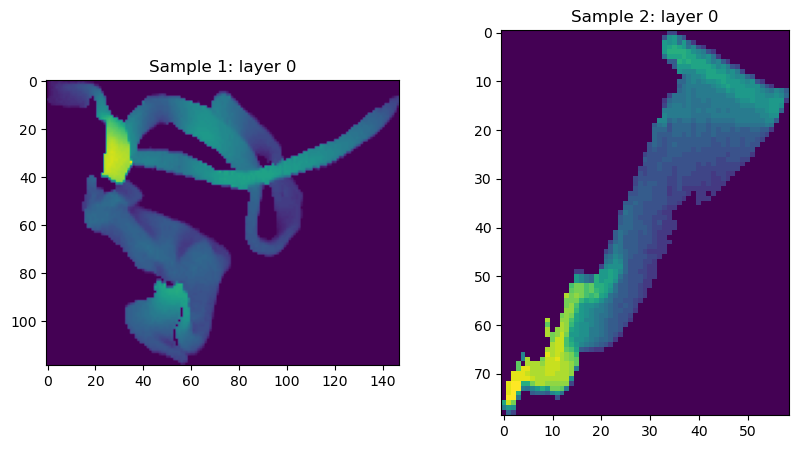

In [91]:
pickle_path = "data\original\dataset_3d_vnir_xrt.pkl"



df = pd.read_pickle(pickle_path)
print("Nb samples: ",len(df))
print("Nb chanels in data_cube: ",len(df["data_cube"][0]))
print("")
print("Shape of 2 random samples: ")
s1, s2 = random.choice(range(len(df))), random.choice(range(len(df)))
print("     sample 1: ",df["data_cube"][s1].shape)
print("     sample 2: ",df["data_cube"][s2].shape)
print("Nb categories: ",len(df["class"].unique()))
classes = df["class"].unique().tolist()
print("Categories: ",classes)
print("Catogories to int: ",{classes[i]:i for i in range(len(classes))})

plt.subplots(1,2,figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(df["data_cube"][s1][0])
plt.title("Sample 1: layer 0")
plt.subplot(1,2,2)
plt.imshow(df["data_cube"][s2][0])
plt.title("Sample 2: layer 0")

pi_data_dict = {0: "3D",
                1: "VNIR 1",
                2: "VNIR 2",
                3: "VNIR 3",
                4: "VNIR 4",
                5: "VNIR 5",
                6: "VNIR 6",
                7: "VNIR 7",
                8: "VNIR 8",
                9: "XRT 1",
                10: "XRT 2"}


### Creation of a dataset class

In [58]:
class PickItDataset(Dataset):    
    def __init__(self, pickle_path, transform=None,train = True, seed = 42):
        data = pd.read_pickle(pickle_path)
        data["cube"] = data["data_cube"].apply(lambda x: x.astype(np.float32))
        cube = data["cube"]
        mask = data["masks"]
        random.seed(seed)
        test_indices = random.sample(range(0, len(data)), int(len(data) * 0.2))
        if train:
            cube = cube.drop(test_indices).reset_index(drop=True)
            mask = mask.drop(test_indices).reset_index(drop=True)
            data = data.drop(test_indices).reset_index(drop=True)
        else:
            cube = cube.iloc[test_indices].reset_index(drop=True)
            mask = mask.iloc[test_indices].reset_index(drop=True)
            data = data.iloc[test_indices].reset_index(drop=True)
        self.data = cube
        self.masks = mask
        self.labels = data["class"].apply(lambda x: classes.index(x))
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            index = index.tolist()

        data = torch.from_numpy(self.data[idx])
        mask = torch.tensor(self.masks[idx])
        label = self.labels[idx]

        sample = {"data": data,"mask":mask, "label": label}

        if self.transform:
            sample = self.transform(sample)

        return sample


### Definition of the transforms

In [59]:
class Rescale(object):
    def __init__(self, scale):
        self.scale = scale

    def __call__(self, sample):
        data, mask ,label = sample["data"], sample["mask"],sample["label"]
        data = transforms.Resize(self.scale)(data)
        mask = transforms.Resize(self.scale)(mask.unsqueeze(0)).squeeze(0)
        return {"data": data,"mask":mask ,"label": label}


class RandomHorizontalFlip(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, sample):
        data, mask, label = sample["data"], sample["mask"], sample["label"]
        if random.random() < self.p:
            data = transforms.RandomHorizontalFlip(p=1)(data)
            mask = transforms.RandomHorizontalFlip(p=1)(mask)
        return {"data": data,"mask":mask ,"label": label}

class RandomVerticalFlip(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, sample):
        data, mask ,label = sample["data"], sample["mask"],sample["label"]
        if random.random() < self.p:
            data = transforms.RandomVerticalFlip(p=1)(data)
            mask = transforms.RandomVerticalFlip(p=1)(mask)
        return {"data": data,"mask":mask ,"label": label}
class RandomRotation(object):
    def __init__(self, p, degrees):
        self.degrees = degrees
        self.p = p 
    
    def __call__(self, sample):
        data, mask ,label = sample["data"], sample["mask"],sample["label"]
        if random.random() < self.p:
            data = transforms.RandomRotation(degrees = self.degrees)(data)
            mask = transforms.RandomRotation(degrees = self.degrees)(mask)
        return {"data": data,"mask":mask ,"label": label}

class Normalize(object):
    def __call__(self, sample):
        data, mask, label = sample["data"], sample["mask"], sample["label"]
        mean = torch.mean(data)
        std = torch.std(data)
        data = transforms.Normalize(mean,std)(data)
        return {"data": data,"mask":mask ,"label": label}
    


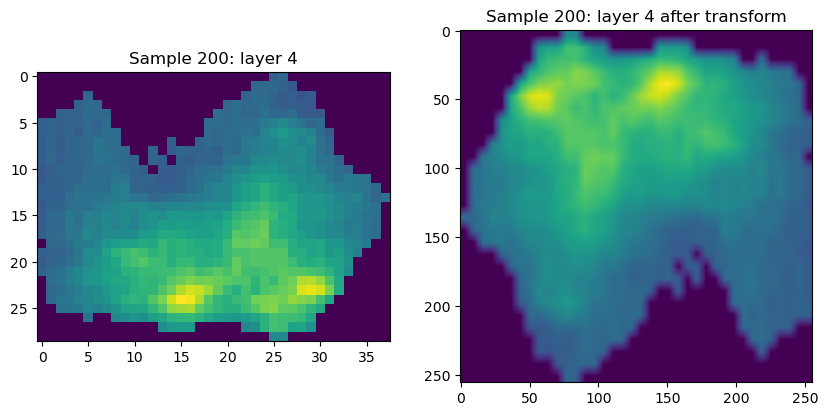

In [68]:
tr_demo = transforms.Compose([Rescale((256,256)),
                            RandomHorizontalFlip(1),
                            RandomVerticalFlip(1),
                            Normalize(),])

def plot_transform(pickle_path, tr_demo, index=200, layer=0):
    demo = PickItDataset(pickle_path, transform=None)
    demo_tr = PickItDataset(pickle_path, transform=tr_demo)

    plt.subplots(1, 2, figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(demo[index]["data"][layer])
    plt.title("Sample "+str(index)+": layer "+str(layer))
    plt.subplot(1, 2, 2)
    plt.imshow(demo_tr[index]["data"][layer])
    plt.title("Sample "+str(index)+": layer "+str(layer)+" after transform")
    plt.show()
    
plot_transform(pickle_path, tr_demo, index=200, layer=4)


### loadind the dataset, applying the transforms and creating the dataloader

In [63]:
new_scale = (256, 256)
p_flip = 0.5
batch_size = 8
num_workers = 0
seed = 42

tr_train = transforms.Compose([Rescale(new_scale),RandomHorizontalFlip(p_flip),RandomVerticalFlip(p_flip),Normalize()])
tr_test = transforms.Compose([Rescale(new_scale),Normalize()])

trainset = PickItDataset(pickle_path, transform=tr_train,train = True, seed = seed)
testset = PickItDataset(pickle_path, transform=tr_test,train = False, seed = seed)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [7]:
print(next(iter(trainloader))["data"].shape)
print(next(iter(trainloader))["mask"].shape)
print(next(iter(trainloader))["label"])

torch.Size([8, 11, 256, 256])
torch.Size([8, 256, 256])
tensor([4, 2, 0, 2, 4, 4, 4, 3])


### Add noise to random image

!python -m pip install -U scikit-image

In [77]:

from skimage.util import random_noise
def salt_paper_noise(p):
    for i, data in enumerate(trainloader, 0):
        img, labels = data["data"], data["label"]
        labels = labels.clone()
        if random.random() < p:
            salt_img = torch.tensor(random_noise(img, mode='salt', amount=0.05))
            print(salt_img)
            all_salt_img = torch.cat(salt_img )
    return all_salt_img
print(salt_paper_noise(0.1))

tensor([[[[-0.6698, -0.6698, -0.6698,  ..., -0.6698, -0.6698, -0.6698],
          [-0.6698, -0.6698, -0.6698,  ..., -0.6698, -0.6698, -0.6698],
          [-0.6698, -0.6698, -0.6698,  ...,  1.0000, -0.6698, -0.6698],
          ...,
          [-0.6698, -0.6698, -0.6698,  ..., -0.6698, -0.6698, -0.6698],
          [-0.6698, -0.6698, -0.6698,  ..., -0.6698, -0.6698, -0.6698],
          [-0.6698, -0.6698, -0.6698,  ..., -0.6698, -0.6698, -0.6698]],

         [[-0.6698, -0.6698, -0.6698,  ..., -0.6698, -0.6698, -0.6698],
          [-0.6698, -0.6698, -0.6698,  ..., -0.6698, -0.6698, -0.6698],
          [-0.6698, -0.6698, -0.6698,  ..., -0.6698, -0.6698, -0.6698],
          ...,
          [-0.6698, -0.6698, -0.6698,  ..., -0.6698, -0.6698, -0.6698],
          [-0.6698, -0.6698, -0.6698,  ...,  1.0000, -0.6698, -0.6698],
          [-0.6698, -0.6698, -0.6698,  ..., -0.6698, -0.6698, -0.6698]],

         [[-0.6698, -0.6698, -0.6698,  ..., -0.6698, -0.6698,  1.0000],
          [-0.6698, -0.6698, -

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

### CNN

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(11, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(59536, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = CNN()


### Loss function and optimizer

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Device


In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Train CNN

In [10]:
nb_epochs = 20

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
losses = []
for epoch in range(nb_epochs):
    losses_epoch = []
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data["data"].to(device), data["label"].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        losses_epoch.append(loss.item())
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/100))
            running_loss = 0.0
    losses.append(losses_epoch)


C:\Users\adrie\AppData\Local\Temp\ipykernel_26844\3282826019.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


KeyboardInterrupt: 

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data["data"].to(device), data["label"].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(testloader)*batch_size} test images: {100 * correct / total} %')

In [ ]:
import plotly.graph_objs as go
import plotly.graph_objects as go


df = pd.read_pickle('data\original\dataset_3d_vnir_xrt.pkl')
def plot_mesh(df, index=0):
    data = df["data_cube"][index][0]
    data = np.pad(data, (3, 3), mode='constant', constant_values=(0, 0))
    x = np.arange(0, data.shape[0], 1)
    y = np.arange(0, data.shape[1], 1)
    mesh = go.Surface(x=x, y=y, z=data, colorscale="Viridis")
    fig = go.Figure(data=[mesh])
    fig.show()
    
plot_mesh(df, index=10)


### Resnet Achitecture


In [ ]:
class Block(nn.Module):
    def __init__(self, input_chan, output_chan, downsample = None, stride= 1):
        super(Block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(input_chan, output_chan, kernel_size= 1, stride=1, padding = 0)
        self.batch_n1 = nn.BatchNorm2d(output_chan)

        self.conv2 = nn.Conv2d(input_chan, output_chan, kernel_size= 1, stride=stride, padding = 1)
        self.batch_n2 = nn.BatchNorm2d(output_chan)

        self.conv3 = nn.Conv2d(output_chan, output_chan*self.expansion, kernel_size= 1, stride=1, padding = 0)
        self.batch_n3 = nn.BatchNorm2d(output_chan*self.expansion)
        self.relu = nn.ReLU()
        self.downsample = downsample

    def forward(self,x):
        identity = x
        x = self.conv1(x)
        x = self.batch_n1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.batch_n2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.batch_n3(x)

        if self.downsample is not None:
            identity = self.downsample(identity)

        x= x + identity
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, Block, layers, channels, num_output):
        super(ResNet, self).__init__()
        self.input_chan = 64
        self.conv1 = nn.Conv2d(channels, 64, kernel_size = 7, stride=2, padding = 3)
        self.batch_n1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        #Resnet layers  

        self.layer1 = self._make_layer(Block,layers[0], output_chan = 64, stride = 1)
        self.layer2 = self._make_layer(Block,layers[1], output_chan = 128, stride = 2)
        self.layer3 = self._make_layer(Block,layers[2], output_chan = 256, stride = 2)
        self.layer4 = self._make_layer(Block,layers[3], output_chan = 512, stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*4, num_output)

    def forward(self,x):
        x = self.conv1(x)
        x = self.batch_n1(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x= self.layer1(x)
        x= self.layer2(x)
        x= self.layer3(x)
        x= self.layer4(x)

        x= self.avgpool(x)
        x = x.reshape(x.shape[0],-1)
        x= self.fc(x)

        return x

    def _make_layer(self, Block, num_residual_blocks, output_chan, stride):
        downsample = None
        layers = []

        if stride != 1 or self.input_chan != output_chan*4:
            downsample = nn.Sequential(nn.Conv2d(self.input_chan, output_chan*4, kernel_size=1, stride = stride),
                                        nn.BatchNorm2d(output_chan*4))
            
        layers.append(Block(self.input_chan, output_chan, downsample, stride))
        self.input_chan = output_chan*4

        for i in range(num_residual_blocks-1):
            layers.append(Block(self.input_chan, output_chan))

        return(nn.Sequential(*layers))


In [42]:
def ResNet50(channels = 11 , num_output = 8):
    return ResNet(Block, [3,4,6,3], channels, num_output)

net = ResNet50()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

NameError: name 'ResNet' is not defined

In [43]:
lr = 3e-4
momentum=0.9 

res_net = resnet50(pretrained = True)
res_net.fc = nn.Linear(in_features = 2048 , out_features = 8)
weight = res_net.conv1.weight.clone()
res_net.conv1 = nn.Conv2d(11, 64, kernel_size=7, stride=2, padding=3,bias=False)

with torch.no_grad():
    res_net.conv1.weight[:, :3] = weight
    res_net.conv1.weight[:, 3] = res_net.conv1.weight[:, 0]

resnet = res_net.to(device)

optimizer = optim.SGD(res_net.parameters(), lr = lr, momentum=momentum)
#maybe try with adam optim
criterion = nn.CrossEntropyLoss()


tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
           -4.3034e-02, -7.0755e-02],
          [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
           -2.0912e-02, -3.8517e-02],
          [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
            6.2641e-02,  5.1977e-02],
          ...,
          [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
           -7.6604e-02,  7.8453e-03],
          [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
           -3.3662e-02, -1.5709e-02],
          [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
            2.2439e-02,  1.7077e-03]],

         [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
            4.4022e-02, -9.4675e-03],
          [-7.7273e-03,  1.8890e-02,  6.7981e-02,  ...,  1.5956e-01,
            1.4606e-01,  1.1999e-01],
          [-4.6013e-02, -7.6075e-02, -8.9648e-02,  ...,  1.2108e-01,
            1.6705e-01,  1.7619e-01],
          ...,
     

### Train and evaluate

In [92]:
nb_epochs = 3
for epoch in range(nb_epochs):
    train_acc = 0
    test_acc = 0

    res_net.train()
    with tqdm(trainloader, unit= "batch") as tepoch :
        for i, data in enumerate(tepoch, 0):
            inputs, labels = data["data"].to(device), data["label"].to(device)
            labels = labels.clone()
            optimizer.zero_grad()

            inputs = inputs.to(device)
            outputs = res_net(inputs)
            outputs = outputs.cpu()
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_pred = torch.max(outputs, 1).indices
            train_acc += int(torch.sum(train_pred == labels))

            running_loss += loss.item()
            losses_epoch.append(loss.item())
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/100))
                running_loss = 0.0
        losses.append(losses_epoch)
        ep_tr_acc = train_acc / len(trainset)
    res_net.eval()
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            inputs_test, labels_test = data["data"].to(device), data["label"].to(device) 
            labels_test = labels_test.clone()
            inputs_test = inputs_test.to(device)
            outputs_test = res_net(inputs_test)
            outputs_test = outputs_test.cpu()

            test_pred = torch.max(outputs_test, 1).indices
            test_acc += int(torch.sum(test_pred == labels_test))
        ep_test_acc = test_acc / len(testset)
    print(f"Epoch: {epoch}, Loss: {loss}\n Train_acc: {ep_tr_acc}\n Test_acc: {ep_test_acc}")


   

 32%|███▏      | 100/317 [22:39<46:21, 12.82s/batch] 

[1,   100] loss: 0.806


 63%|██████▎   | 200/317 [45:15<28:00, 14.36s/batch]

[1,   200] loss: 0.542


 95%|█████████▍| 300/317 [1:11:00<04:02, 14.28s/batch]

[1,   300] loss: 0.514


100%|██████████| 317/317 [1:14:51<00:00, 14.17s/batch]


Epoch: 0, Loss: 0.13254009187221527
 Train_acc: 0.8301066772026867
 Test_acc: 0.9129746835443038


 32%|███▏      | 100/317 [22:35<49:05, 13.57s/batch] 

[2,   100] loss: 0.592


 63%|██████▎   | 200/317 [45:01<24:52, 12.76s/batch]

[2,   200] loss: 0.464


 95%|█████████▍| 300/317 [1:07:53<03:20, 11.82s/batch]

[2,   300] loss: 0.439


100%|██████████| 317/317 [1:10:58<00:00, 13.43s/batch]


Epoch: 1, Loss: 0.1404811143875122
 Train_acc: 0.8589490320031608
 Test_acc: 0.9066455696202531


 32%|███▏      | 100/317 [18:53<41:33, 11.49s/batch] 

[3,   100] loss: 0.449


 63%|██████▎   | 200/317 [38:11<22:28, 11.53s/batch]

[3,   200] loss: 0.456


 95%|█████████▍| 300/317 [57:06<03:15, 11.51s/batch]

[3,   300] loss: 0.394


100%|██████████| 317/317 [1:00:14<00:00, 11.40s/batch]


Epoch: 2, Loss: 0.15423570573329926
 Train_acc: 0.8826550770446464
 Test_acc: 0.9034810126582279


In [17]:
nb_epochs = 1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
losses = []
for epoch in range(nb_epochs):
    losses_epoch = []
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data["data"].to(device), data["label"].to(device)
        labels = torch.tensor(labels)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        losses_epoch.append(loss.item())

       
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/100))
            running_loss = 0.0
    losses.append(losses_epoch)


C:\Users\adrie\AppData\Local\Temp\ipykernel_26844\3217525094.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


KeyboardInterrupt: 